  <div class="alert alert-info">
  Привет, Юрий! Меня зовут Светлана Чих и я буду проверять твой проект. Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе. Предлагаю общаться на «ты». Но если это не удобно - дай знать, и мы перейдем на «вы».

  <div class="alert alert-success">
  <b>👍 Успех:</b> Зелёным цветом отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах.
  </div>
  <div class="alert alert-warning">
  <b>🤔 Рекомендация:</b> Жёлтым цветом выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).
  </div>
  <div class="alert alert-danger">
  <b>😔 Необходимо исправить:</b> Красным цветом выделены комментарии, без исправления которых, я не смогу принять проект :(
  </div>
  <div class="alert alert-info">
  <b>👂 Совет:</b> Какие-то дополнительные материалы
  </div>
  Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
  Мне будет легче отследить изменения, если ты выделишь свои комментарии:
  <div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Например, вот так.</div>
  Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта быстрее.
   </div>

# Описание проекта
Необходимо создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

# Схема таблиц

![Схема таблиц](https://pictures.s3.yandex.net/resources/PPROD-4019_1725013595.png)

# Краткое описание таблиц
- **collisions — общая информация о ДТП**\
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

- **parties — информация об участниках ДТП**\
Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

- **vehicles — информация о пострадавших машинах**\
Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

In [6]:
!pip install sqlalchemy
!pip install phik
!pip install psycopg2-binary
!pip install shap
!pip install lightgbm

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, MetaData
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

from sklearn.model_selection import train_test_split
from phik.report import plot_correlation_matrix
from phik import report

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    f1_score, 
    roc_auc_score,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    recall_score, 
    precision_score
)

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb

<div class="alert alert-success">
<b>👍 Успех:</b> Импортированы нужные библиотеки!
</div>

## Подключитесь к базе. Загрузите таблицы sql

Объявим учетные данные для подключения к базе данных

In [11]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
} 

In [12]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [13]:
engine = create_engine(connection_string)

<div class="alert alert-success">
<b>👍 Успех:</b> Создано подключение к БД!
</div>

## Проведите первичное исследование таблиц

In [16]:
def primary_information(table):
    select_10_query = '''
    SELECT *
    FROM {}
    LIMIT 10
    '''
    count_all_query = '''
    SELECT COUNT(*)
    FROM {}
    '''
    printmd(f"Количество строк: {pd.read_sql_query(count_all_query.format(table), con = engine)['count'][0]}")
    df = pd.read_sql_query(select_10_query.format(table), con = engine)
    display(df.info())
    display(df.head())

Получим первичную информацию о таблицах

In [18]:
printmd("**Таблица vehicles**")
primary_information('vehicles')
printmd("**Таблица collisions**")
primary_information('collisions')
printmd("**Таблица parties**")
primary_information('parties')

**Таблица vehicles**

Количество строк: 1021234

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    10 non-null     int64 
 1   case_id               10 non-null     object
 2   party_number          10 non-null     int64 
 3   vehicle_type          10 non-null     object
 4   vehicle_transmission  10 non-null     object
 5   vehicle_age           10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


None

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


**Таблица collisions**

Количество строк: 1400000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 non-null     object 
 13  motor_vehicle_involved_

None

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


**Таблица parties**

Количество строк: 2752408

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10 non-null     int64  
 1   case_id              10 non-null     object 
 2   party_number         10 non-null     int64  
 3   party_type           10 non-null     object 
 4   at_fault             10 non-null     int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       10 non-null     object 
 7   party_drug_physical  4 non-null      object 
 8   cellphone_in_use     9 non-null      float64
dtypes: float64(2), int64(3), object(4)
memory usage: 852.0+ bytes


None

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


Таблицы соответствуют описанию. Все таблицы имеют общий ключ ```case_id```

<div class="alert alert-success">
<b>👍 Успех:</b> Проведено ознакомление с таблицами, молодец, что ограничиваешь запрос 10-ю строками, этого достаточно для ознакомления с данными!
</div>

##  Проведите статистический анализ факторов ДТП

Выясним, в какие месяцы происходит наибольшее количество аварий.

In [23]:
query = '''
SELECT EXTRACT(YEAR FROM collision_date)::INT as year,
       (EXTRACT(MONTH FROM collision_date)-1)::INT as month_num,
       to_char(collision_date, 'TMMonth') as month,
       COUNT(case_id)
FROM collisions
GROUP BY EXTRACT(YEAR FROM collision_date)::INT, (EXTRACT(MONTH FROM collision_date)-1)::INT, to_char(collision_date, 'TMMonth');
'''
df = pd.read_sql_query(query, con = engine)
df_pivot = df.pivot(index='month_num', 
                    columns='year',
                    values='count')
df_pivot['month'] = df['month']
df_pivot.set_index('month', inplace=True)
df_pivot

year,2009,2010,2011,2012,2013,2020
month,,,,,,
January,35062.0,32892.0,31926.0,32020.0,144.0,NaN
February,34480.0,31918.0,31975.0,30377.0,108.0,NaN
March,36648.0,35803.0,34585.0,32498.0,46.0,1.0
April,35239.0,34416.0,31377.0,29143.0,5.0,NaN
May,36916.0,34862.0,33370.0,25168.0,NaN,NaN
June,34202.0,33367.0,31962.0,3062.0,1.0,NaN
July,35161.0,33645.0,33029.0,390.0,1.0,1.0
August,34508.0,34620.0,34339.0,622.0,NaN,NaN
September,35555.0,34957.0,34137.0,510.0,NaN,NaN


Данные за 2013 и 2020 год неполные, удалим эти столбцы

In [25]:
df_pivot = df_pivot.drop([2013, 2020], axis=1)

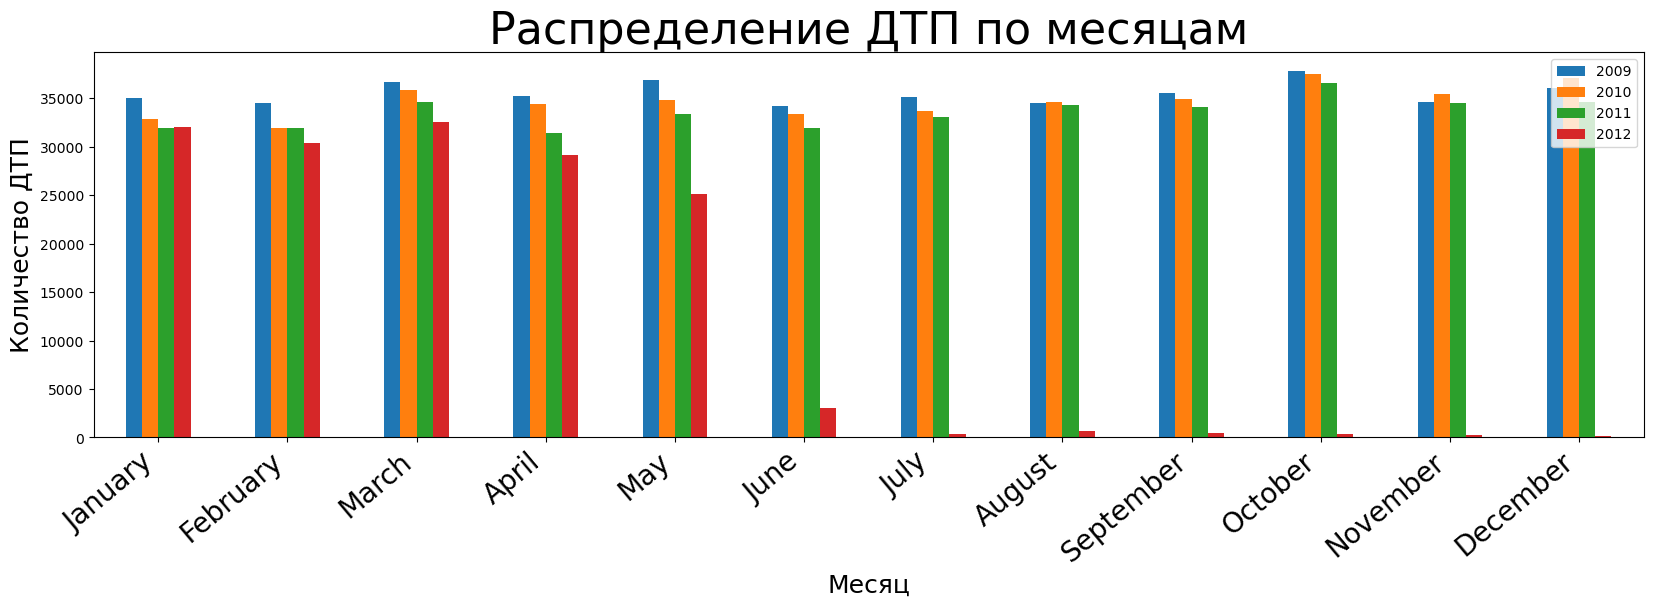

In [26]:
ax = df_pivot.plot(kind='bar', figsize=(20, 5))
plt.title('Распределение ДТП по месяцам', fontsize=32)
plt.xlabel('Месяц', fontsize=18)
plt.ylabel('Количество ДТП', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right')
ax.legend(loc='upper right');

Согласно распределению ДТП по месяцам можно сделать вывод, что период осень и весна наиболее аварийноопасные. Также, согласно выгрузке, данные за 2012 год неполные. 

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Здесь нужно проверить полноту даных, например, вывести линейный график (столбчатую диаграмму) количества ДТП разделив его цветом по годам</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Здесь видно, что 2012 год неполный, но по таким данным можно сделать верный вывод
</div>

На повестке первого совещания рабочей группы, проработаем подходящие аналитические задачи:
- Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (таблица collisions);
- Найдите самые частые причины ДТП (таблица parties);
- Найдите аврийноопасное время (таблица collisions);
- Провести анализ серьёзности повреждений транспортного средства, исходя из погоды в момент ДТП (таблица collisions);
- Одной из причин аварий бывает ослепление водителей заходящим и восходящим солнцем на горизонте. Проверить теорию, связав время суток и направление движения ТС на момент ДТП (таблица collisions);
- Проанализировать какую долю ДТП занимают ДТП с участниками в алкогольном опьянении (связать collisions и parties)
- Проанализировать какую долю ДТП занимают ДТП с участниками в сонном состоянии (связать collisions и parties)
- Сравнить количество ДТП с разным типом КПП (связать collisions, parties и vehicles);

Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП

In [32]:
query = '''
SELECT COUNT(DISTINCT case_id),
       collision_damage,
       road_surface 
FROM collisions
GROUP BY collision_damage, road_surface;
'''
df = pd.read_sql_query(query, con = engine)
df = df.dropna()
df_pivot = df.pivot(index='collision_damage', 
                          columns='road_surface',
                          values='count')
df_pivot

road_surface,dry,slippery,snowy,wet
collision_damage,,,,
fatal,9823,12,46,857
middle damage,151015,238,762,13190
scratch,307963,308,1259,33301
severe damage,27827,64,157,2470
small damage,745398,762,5037,86418


In [33]:
def show_pie(df, columns, main_title, colors=None):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), sharey=True, figsize=(18, 6))
    palette_color = sns.color_palette('pastel') 
    if len(columns) == 1:
        (
            df[columns[0]].plot.pie(autopct='%1.f%%', legend=False, colors=palette_color,
                wedgeprops = {"edgecolor" : "white", 
                              'linewidth': 2, 
                              'antialiased': True})
        )
    else:
        idx = 0
        for column in columns:    
            (
                df[column].plot.pie(ax=axes[idx], autopct='%1.f%%', legend=False, colors=palette_color,
                    wedgeprops = {"edgecolor" : "white", 
                                  'linewidth': 2, 
                                  'antialiased': True})
            )
            axes[idx].title.set_text(columns[idx])
            idx+=1
    fig.suptitle(main_title, fontsize=30)

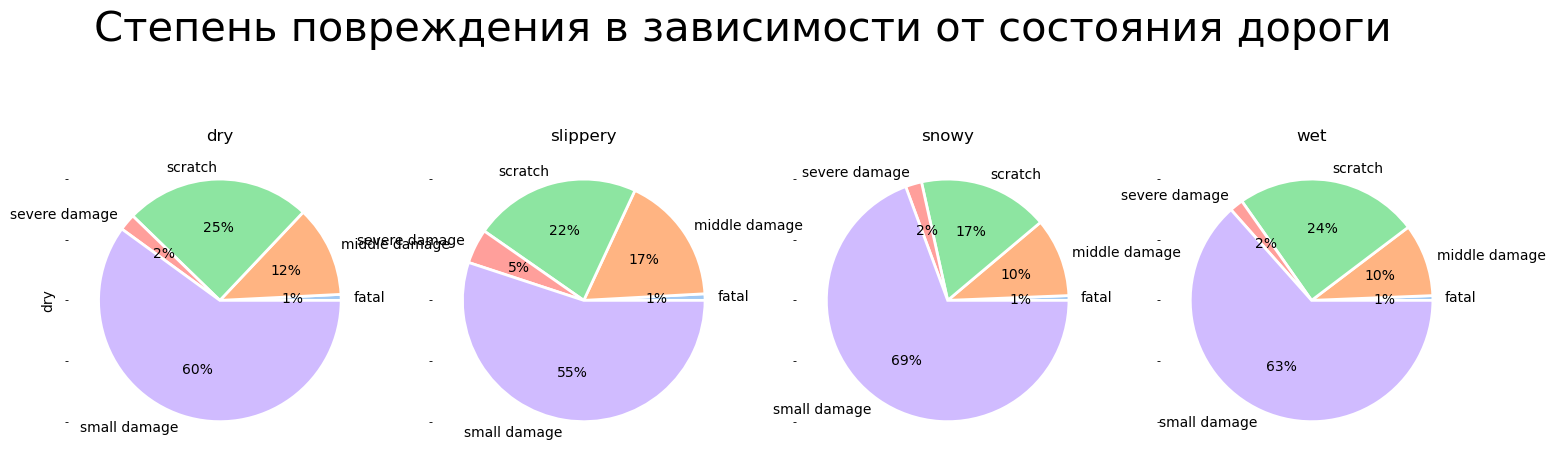

In [34]:
show_pie(df_pivot, df_pivot.columns, "Степень повреждения в зависимости от состояния дороги")

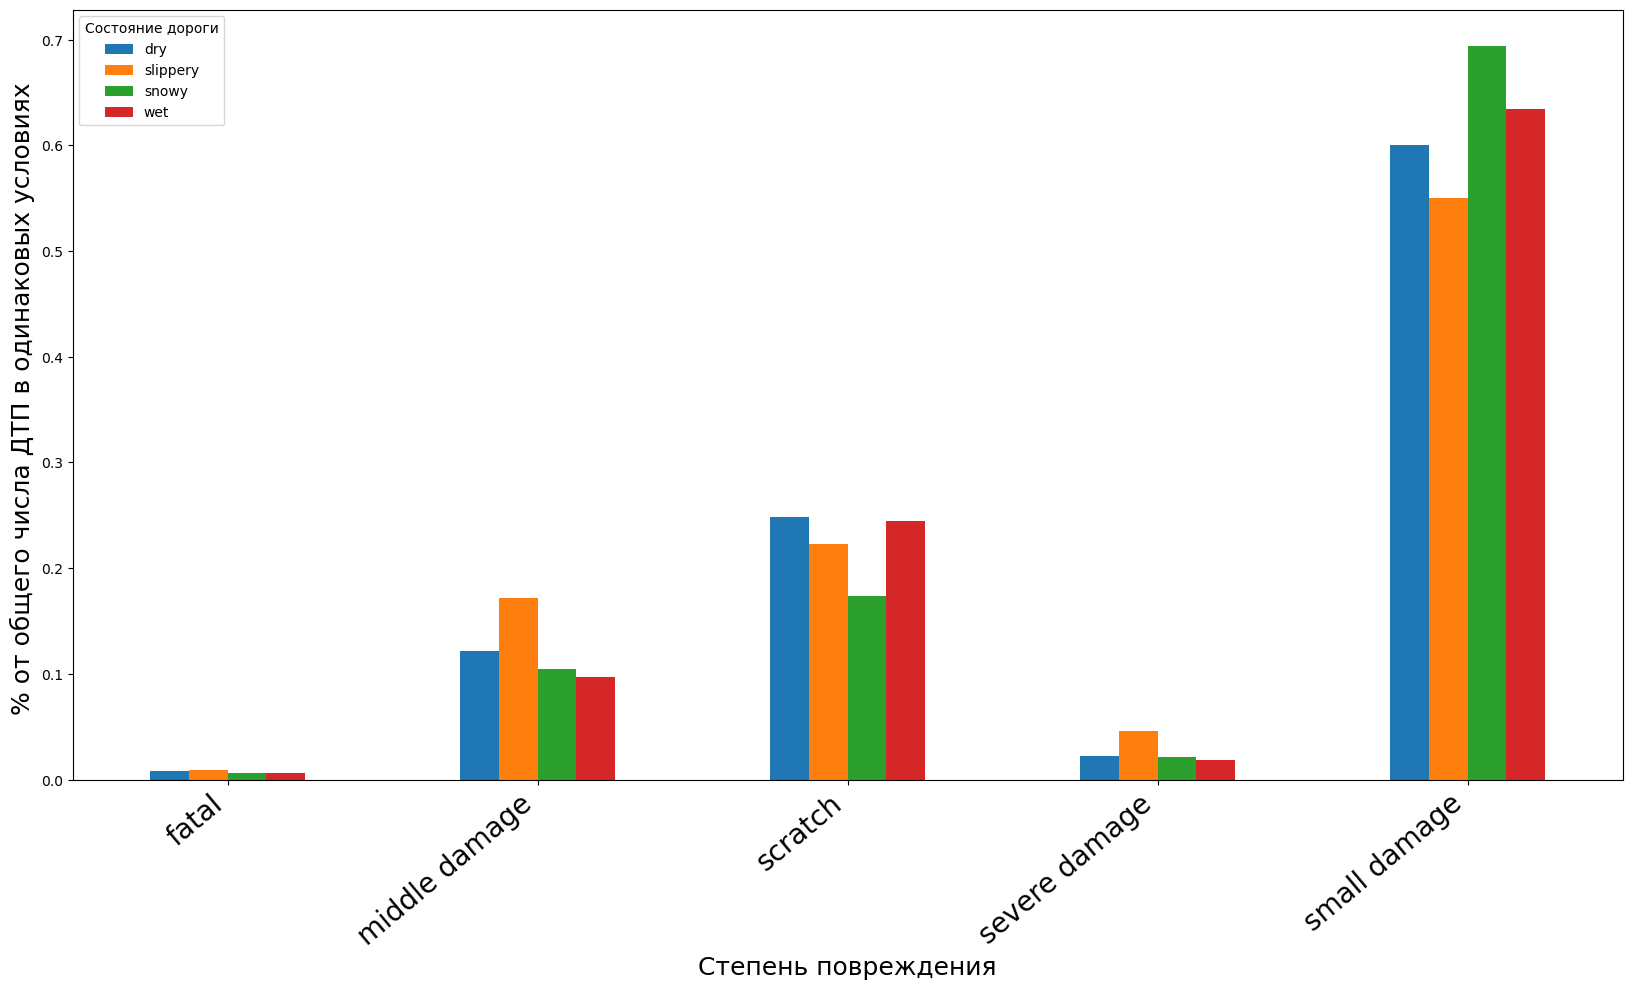

In [35]:
for col in df_pivot.columns:
    df_pivot[col] = df_pivot[col] / df_pivot[col].sum()
df_pivot.plot(kind='bar', figsize=(20, 10))
plt.xlabel('Степень повреждения', fontsize=18);
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right')
plt.ylabel('% от общего числа ДТП в одинаковых условиях ', fontsize=18);
plt.legend(title="Состояние дороги");

В соответствии с диаграммами можно сделать вывод, по статистике, ДТП с наиболее тяжелыми последствиями происходят на скользкой дороге. ДТП с небольшими повреждениями чаще случаются на влажном и снежном покрытии.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

Теперь проанализируем какую долю ДТП занимают ДТП с участниками в алкогольном опьянении

In [39]:
query = '''
SELECT COUNT(DISTINCT c.case_id),
       p.party_sobriety
FROM collisions c
JOIN parties p ON c.case_id=p.case_id
GROUP BY p.party_sobriety;
'''
df = pd.read_sql_query(query, con = engine)
df = df.dropna()
df.set_index('party_sobriety', inplace=True)
df

,count
party_sobriety,
"had been drinking, impairment unknown",20975
"had been drinking, not under influence",15967
"had been drinking, under influence",111559
had not been drinking,1185724
impairment unknown,224079
not applicable,129640


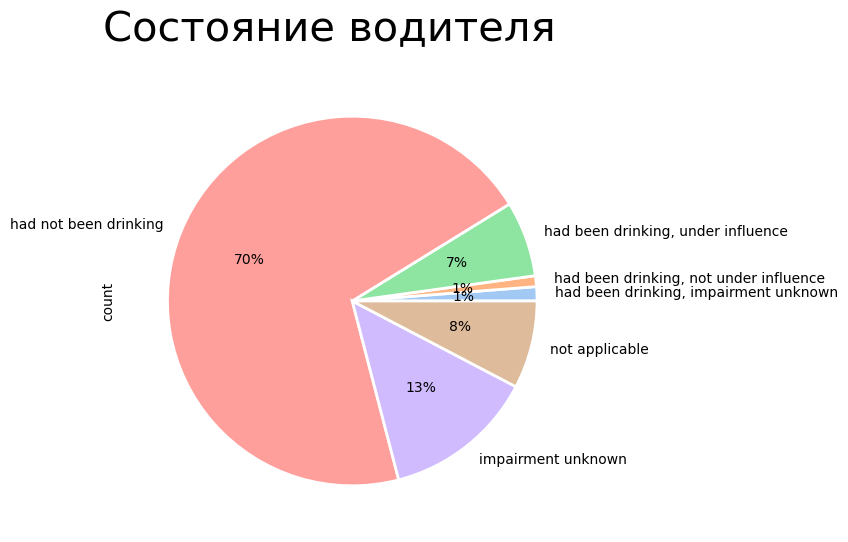

In [40]:
show_pie(df, ['count'], "Состояние водителя")

Количество ДТП с участниками, находившимися в состоянии алкогольного опьянения, не такое большое, но все-таки занимает значительную часть от общего числа ДТП.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

Построим еще один график для понимания в какое время суток происходит наибольшее количество ДТП.

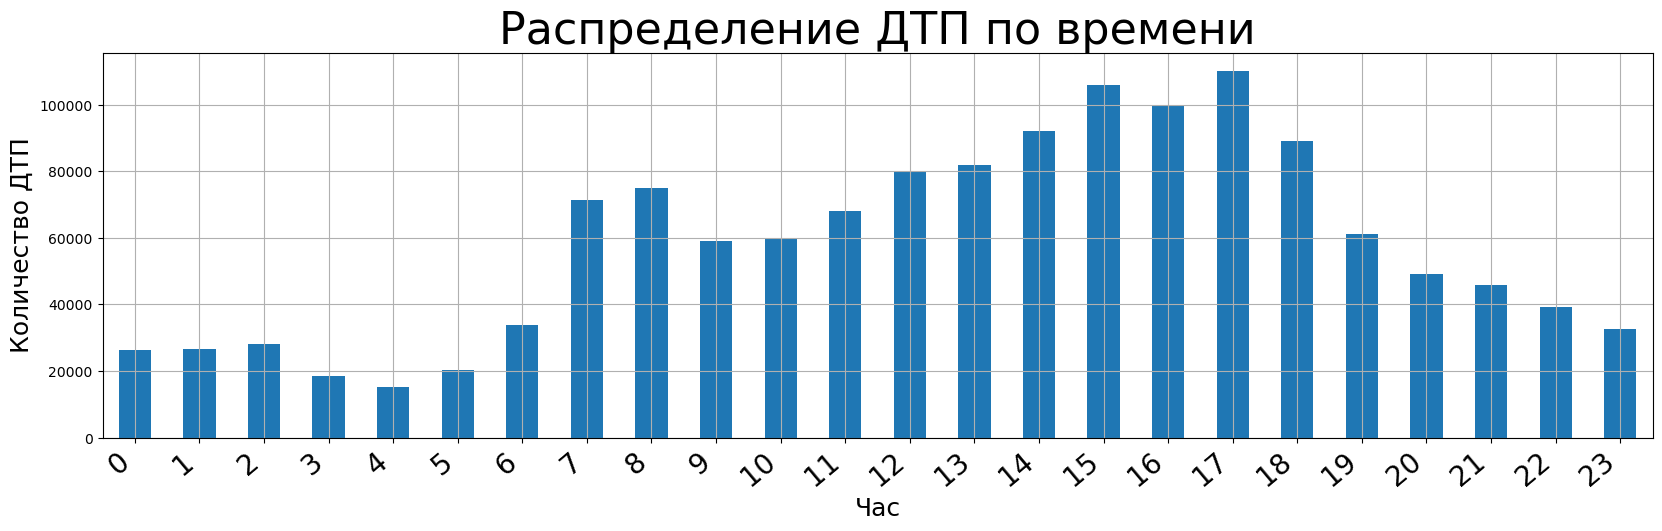

In [44]:
query = '''
WITH collision_hour_time AS (
    SELECT EXTRACT(HOUR FROM collision_time)::int as hr,
           COUNT(case_id) OVER (PARTITION BY EXTRACT(HOUR FROM collision_time)) as cnt,
           ROW_NUMBER() OVER (PARTITION BY EXTRACT(HOUR FROM collision_time)) as rn
    FROM collisions
)
SELECT *
FROM collision_hour_time
WHERE rn = 1;
'''
df = pd.read_sql_query(query, con = engine)
df = df.dropna()
df['hr'] = df['hr'].astype(int)
df.plot(kind='bar', x='hr', y='cnt', grid=True, figsize=(20, 5))
plt.title('Распределение ДТП по времени', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество ДТП', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right')
plt.legend().remove();

График распределения ДТП по времени суток показывает, что больше всего аварий происходит в часы пик, когда большое количество людей едут на работу или с работы.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

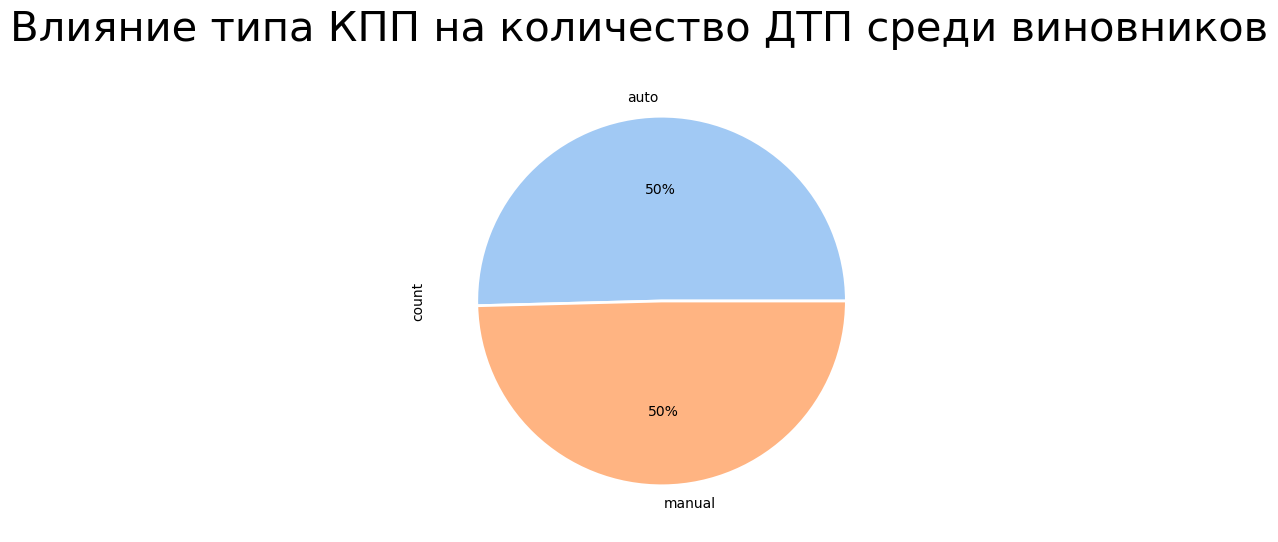

In [47]:
query = '''
SELECT COUNT(c.case_id),
       v.vehicle_transmission
FROM collisions c
JOIN vehicles v ON c.case_id=v.case_id
JOIN parties p ON c.case_id=p.case_id
WHERE p.at_fault=1
GROUP BY v.vehicle_transmission;
'''
df = pd.read_sql_query(query, con = engine)
df = df.dropna()
df.set_index('vehicle_transmission', inplace=True)
show_pie(df, ['count'], "Влияние типа КПП на количество ДТП среди виновников")

Тип КПП на вероятность ДТП не влияет.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

Одной из причин аварий бывает ослепление водителей заходящим и восходящим солнцем на горизонте. Проверим теорию, связав время суток и направление движения ТС на момент ДТП

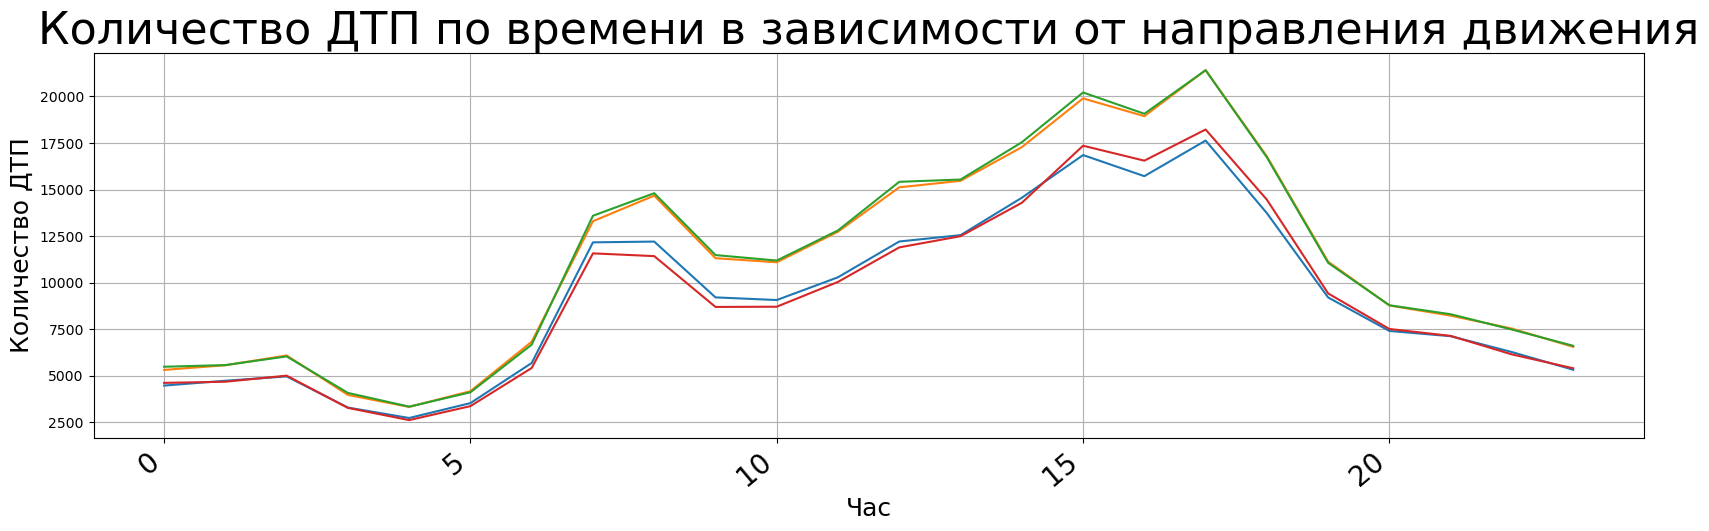

In [51]:
query = '''
WITH collision_hour_time AS (
    SELECT EXTRACT(HOUR FROM c.collision_time)::int as hr,
           COUNT(c.case_id) OVER (PARTITION BY EXTRACT(HOUR FROM c.collision_time), c.direction) as cnt,
           ROW_NUMBER() OVER (PARTITION BY EXTRACT(HOUR FROM c.collision_time), c.direction) as rn,
           c.direction as direction
    FROM collisions c
    JOIN parties p ON c.case_id=p.case_id
    WHERE p.at_fault=1
)
SELECT *
FROM collision_hour_time
WHERE rn = 1;
'''
df = pd.read_sql_query(query, con = engine)
df = df.dropna()
df['hr'] = df['hr'].astype(int)

df_pivot = df.pivot(index='hr', 
                    columns='direction',
                    values='cnt')
df_pivot.plot(figsize=(20, 5), grid=True)
plt.title('Количество ДТП по времени в зависимости от направления движения', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество ДТП', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right')
plt.legend().remove();

Теория не подтвердилась. Однако направление на север или юг в любое время суток более аварийноопасное, примем это к сведению.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

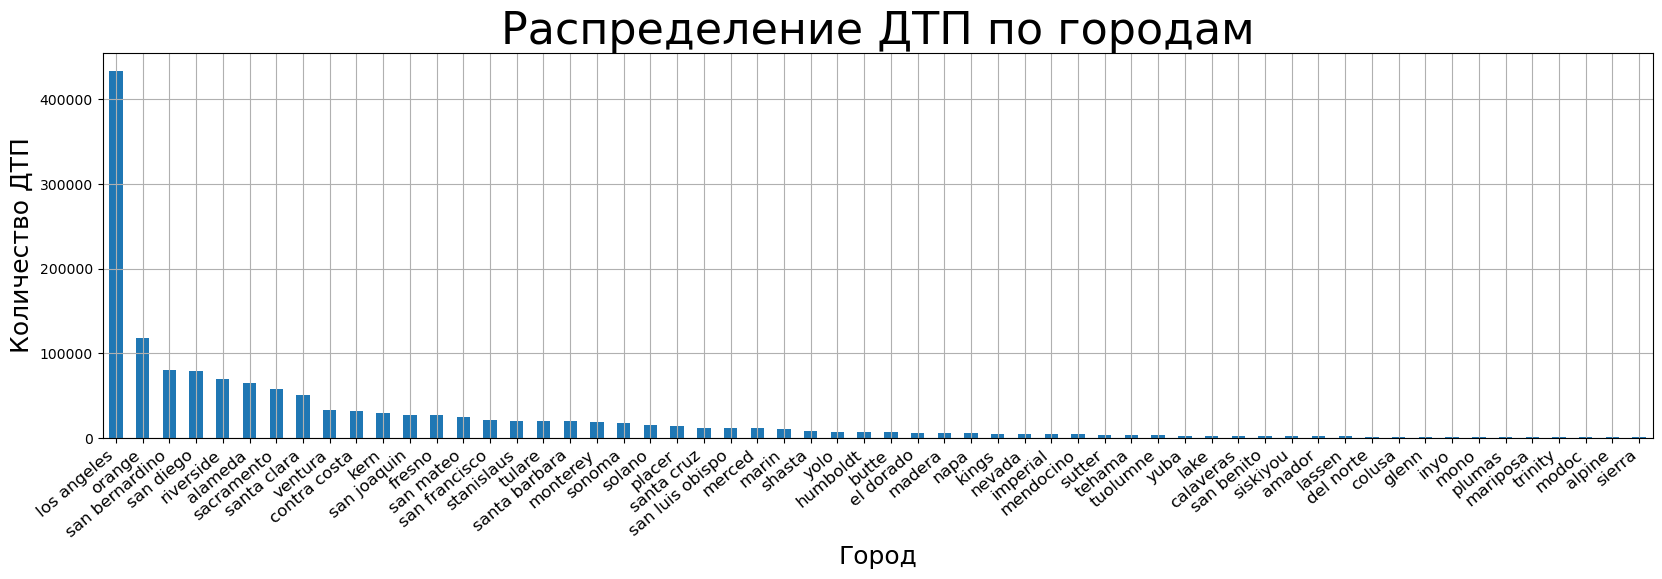

In [54]:
query = '''
SELECT COUNT(case_id), 
       county_location
FROM collisions
GROUP BY county_location
ORDER BY COUNT(case_id) DESC;
'''
df = pd.read_sql_query(query, con = engine)
df = df.dropna()

df.plot(kind='bar', x='county_location', y='count', grid=True, figsize=(20, 5))
plt.title('Распределение ДТП по городам', fontsize=32)
plt.xlabel('Город', fontsize=18)
plt.ylabel('Количество ДТП', fontsize=18)
plt.xticks(fontsize=12, rotation=40, horizontalalignment='right')
plt.legend().remove();

В разных городах разный трафик. Поэтому и вероятность ДТП зависит от города

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Создайте модель для оценки водительского риска

Создадим модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

In [59]:
columns = [
    'county_location', # В разных городах разный трафик. Поэтому и вероятность ДТП зависит от города
    'direction', # Исследование показало, что направление на север и югболее аварийноопасное
    'weather_1', # Погода влияет на много факторо, такие как видимость, сцепление с дорогой
    'road_surface', # Состояние дороги влияет на вероятность ДТП и на степень повреждений
    'road_condition_1', 
    'collision_date', # Согласно анализу, зима и весна более аварийноопасные времена 
    'collision_time', # Согласно анализу, час пик более аварийноопасное время
    'at_fault', # Целевой признак
    'party_sobriety', # Один из вариантов заказчика оборудовать ТС алкотестером, поэтому 
    'vehicle_age' # Возраст автомобиля влияет на его техническое состояние и как следствие на вероятность ДТП 
]

In [60]:
query = f'''
SELECT {','.join(columns)}
FROM collisions c
JOIN parties p ON c.case_id=p.case_id
JOIN vehicles v ON c.case_id=v.case_id AND p.party_number=v.party_number
WHERE p.party_type='car' AND
      c.collision_damage!='scratch' AND
      EXTRACT(YEAR FROM c.collision_date)=2012;
'''
df_collisions = pd.read_sql_query(query, con = engine)

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> vehicles имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number. После исправления запроса часть ниже измениться, я проверю ее в следующей итерации</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [63]:
display(df_collisions.info())
display(df_collisions.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   county_location   56248 non-null  object 
 1   direction         43230 non-null  object 
 2   weather_1         56080 non-null  object 
 3   road_surface      55900 non-null  object 
 4   road_condition_1  55999 non-null  object 
 5   collision_date    56248 non-null  object 
 6   collision_time    56160 non-null  object 
 7   at_fault          56248 non-null  int64  
 8   party_sobriety    55376 non-null  object 
 9   vehicle_age       54554 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 4.3+ MB


None

,county_location,direction,weather_1,road_surface,road_condition_1,collision_date,collision_time,at_fault,party_sobriety,vehicle_age
0,ventura,north,clear,dry,normal,2012-04-19,12:44:00,0,impairment unknown,NaN
1,san bernardino,north,clear,dry,normal,2012-04-19,22:04:00,1,had not been drinking,8.0
2,nevada,east,clear,dry,normal,2012-04-21,00:50:00,1,"had been drinking, under influence",6.0
3,kings,east,cloudy,wet,normal,2012-04-13,14:34:00,1,had not been drinking,11.0
4,solano,south,cloudy,dry,normal,2012-01-02,15:32:00,1,had not been drinking,3.0


In [64]:
df_collisions['collision_time'] = pd.to_datetime(df_collisions['collision_time'], format='%H:%M:%S')
df_collisions['collision_date'] = pd.to_datetime(df_collisions['collision_date'], format='%Y-%m-%d')
df_collisions['hour'] = df_collisions['collision_time'].dt.hour
df_collisions['month'] = df_collisions['collision_date'].dt.month

In [65]:
df_collisions.drop(['collision_date', 'collision_time'], inplace = True, axis=1)

После отбора признаков, проверим датасет на дубликаты

In [67]:
df_collisions[df_collisions.duplicated()]

,county_location,direction,weather_1,road_surface,road_condition_1,at_fault,party_sobriety,vehicle_age,hour,month
126,los angeles,east,clear,dry,normal,0,had not been drinking,3.0,17.0,1
264,los angeles,north,clear,dry,normal,0,had not been drinking,3.0,19.0,1
268,los angeles,west,clear,dry,normal,0,had not been drinking,4.0,15.0,1
506,riverside,east,clear,dry,normal,0,had not been drinking,NaN,21.0,2
542,los angeles,south,clear,dry,normal,0,had not been drinking,6.0,19.0,1
...,...,...,...,...,...,...,...,...,...,...
56197,los angeles,None,clear,dry,normal,0,had not been drinking,3.0,15.0,2
56198,los angeles,east,clear,dry,normal,0,had not been drinking,9.0,8.0,3
56202,san diego,west,clear,dry,normal,1,had not been drinking,4.0,14.0,2
56217,los angeles,None,clear,dry,normal,0,had not been drinking,5.0,23.0,2


In [68]:
df_collisions.drop_duplicates(inplace = True)

In [69]:
df_collisions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48690 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   county_location   48690 non-null  object 
 1   direction         37719 non-null  object 
 2   weather_1         48523 non-null  object 
 3   road_surface      48349 non-null  object 
 4   road_condition_1  48445 non-null  object 
 5   at_fault          48690 non-null  int64  
 6   party_sobriety    47825 non-null  object 
 7   vehicle_age       47130 non-null  float64
 8   hour              48602 non-null  float64
 9   month             48690 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(6)
memory usage: 3.9+ MB


In [70]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Процент пропусков' + "\n", fontsize = 22, color = 'SteelBlue')
        );
    except:
        print('Пропусков нет')

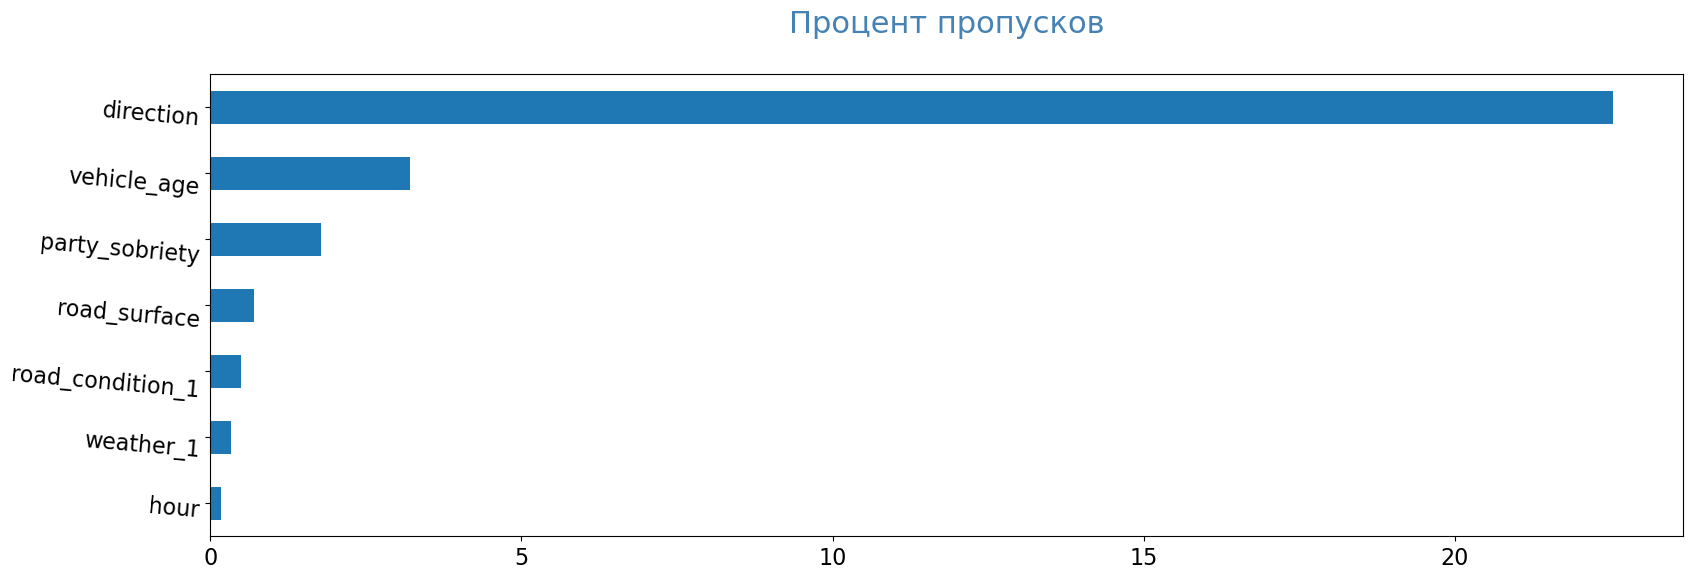

In [71]:
pass_value_barh(df_collisions)

Записи с пропусками в полях удалим.

In [73]:
df_collisions = df_collisions.dropna(subset=['vehicle_age', 'party_sobriety', 'road_surface', 'road_condition_1', 'weather_1', 'hour'])
df_collisions['direction'] = df_collisions['direction'].fillna('unknown')

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> Сколько данных было удалено?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Изменил решение</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Хороший вариант заполнения пропусков
</div>

interval columns not set, guessing: ['at_fault', 'vehicle_age', 'hour', 'month']


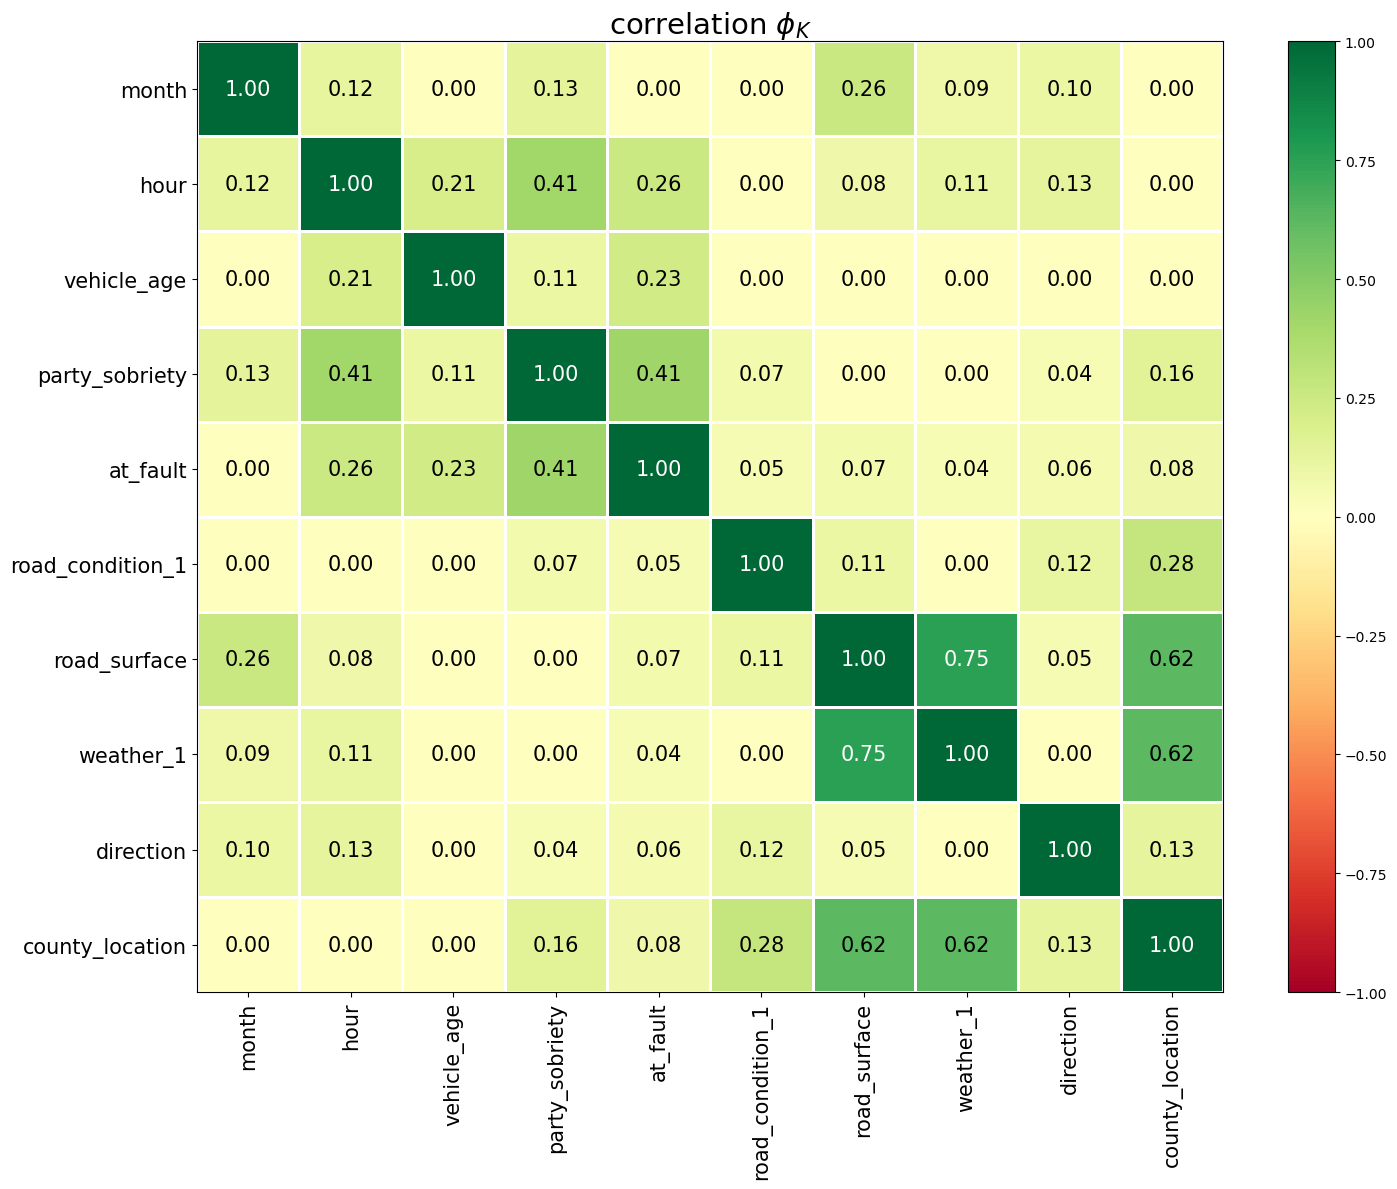

In [76]:
phik_overview = df_collisions.sample(1000).phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
);

### Подготовка пайплайна к обучению

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> Какая метрика была выбрана? Почему?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Добавил</div>

В качестве метрики качества можели выберем ROC AUC. Это метрика, которая используется для оценки качества бинарных классификаторов. Она показывает, насколько хорошо модель может отличать положительные примеры от отрицательных.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Можно еще подусать об использовании F1
</div>

In [81]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [82]:
num_columns = [
    'month',
    'hour',
    'vehicle_age'
]
ohe_columns = [
    'county_location',
    'direction',
    'weather_1',
    'road_surface',
    'road_condition_1', 
    'party_sobriety', 
]
target_column = 'at_fault'

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    df_collisions[ohe_columns+num_columns],
    df_collisions[target_column],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_collisions[target_column])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34234, 9), (11412, 9), (34234,), (11412,))

In [84]:
ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> SimpleImputer здесь не нужен</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Удалил</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [87]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [88]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [89]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LGBMClassifier()
    {
        'models': [lgb.LGBMClassifier()],
        'models__num_leaves': [2, 8, 32],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

### Обучение моделей

In [91]:
searchcv = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
searchcv.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', searchcv.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', searchcv.best_score_)

[LightGBM] [Info] Number of positive: 17805, number of negative: 16429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 34234, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520097 -> initscore=0.080431
[LightGBM] [Info] Start training from score 0.080431
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output

In [92]:
y_test_pred = searchcv.predict(X_test)

In [93]:
print(f"Метрика roc_auc score на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}")

Метрика roc_auc score на тестовой выборке: 0.6202004483174804


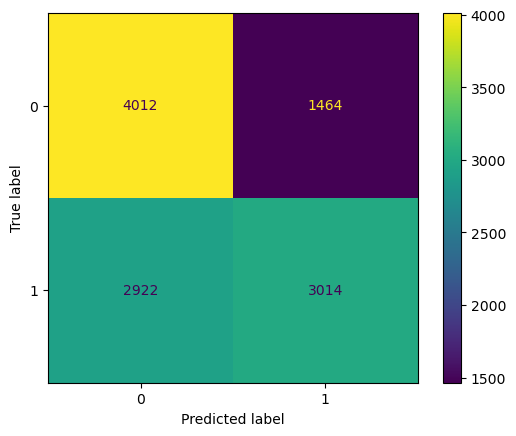

In [94]:
c_matrix = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

Видно, что в матрице преобладает главная диаглналь, это говорит о том что модель в большинстве случаев успешно справляется с предсказаниями

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Проведите анализ важности факторов ДТП

In [97]:
SAMPLE_COUNT=25

In [98]:
best_model = searchcv.best_estimator_.named_steps['models']
preprocessor = searchcv.best_estimator_.named_steps['preprocessor']

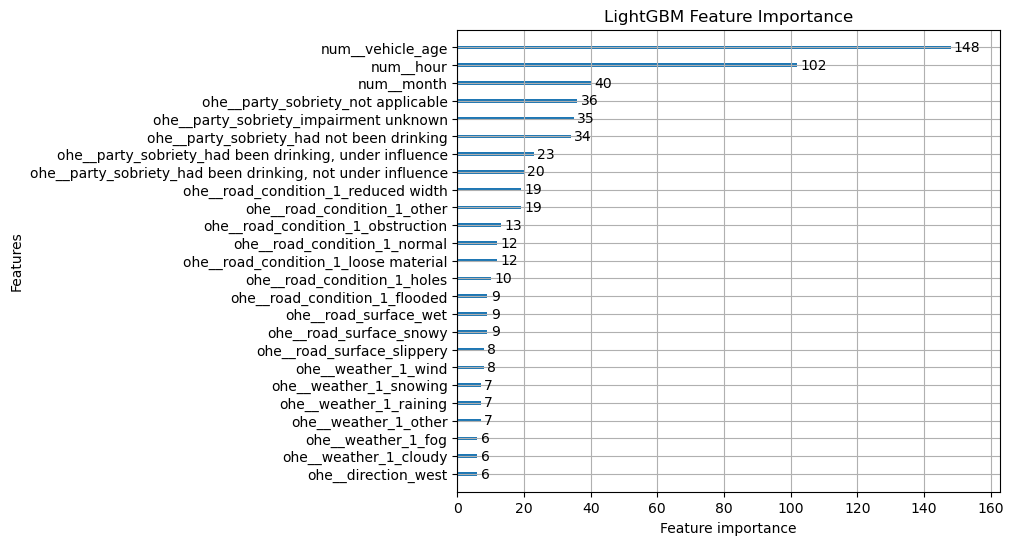

In [99]:
ax = lgb.plot_importance(best_model, figsize=(7,6), max_num_features=SAMPLE_COUNT, ignore_zero=False, title="LightGBM Feature Importance")
ax.set_yticklabels(searchcv.best_estimator_.named_steps.preprocessor.get_feature_names_out()[-SAMPLE_COUNT:]);

Наиболее влиятельные факторы это:
- возраст автомобиля
- состояние алкогольного опьянения
- время суток
- время года

Предлагается:
- оборудовать автомобиль анализатором алкогольного опьянения
- регулировать цены на аренду в зависимости от времени суток, времени года
- чаще обновлять автопарк

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Выводы

В ходе работы было выполнено подключение к базе данных и получены таблицы для работы. Таблицы соответствуют описанию. Все таблицы имеют общий ключ ```case_id```. Для анализа были поставлены следующие задачи:
- Найти самые частые причины ДТП
- Найдите аврийноопасное время
- Провести анализ серьёзности повреждений транспортного средства, исходя из погоды в момент ДТП
- Проанализировать какую долю ДТП занимают ДТП с участниками в алкогольном опьянении
- Сравнить количество ДТП с разным типом КПП (связать collisions, parties и vehicles)

Поставленные задачи были успешно проанализированы и на основе их результатов было выгружен датасет для обучения моделей. Были обучены модели:
- DecisionTreeClassifier
- LogisticRegression
- LGBMClassifier

Наилучшую метрику показала модель LGBMClassifier. Исходя из результатов обучения были выявлены аиболее влиятельные факторы на вероятность ДТП:
- состояние алкогольного опьянения
- возраст автомобиля
- время суток
- время года

Предлагается:
- оборудовать автомобиль анализатором алкогольного опьянения
- регулировать цены на аренду в зависимости от времени суток, времени года и города
- чаще обновлять автопарк

<div class="alert alert-success">
<b>👍 Успех:</b> Отличная работа! Было очень приятно проверять твой проект!

Оставлю хороший учебник по ML:
+  https://academy.yandex.ru/handbook/ml

Немного новостей с мира DL(вдруг заинтересует):
+  https://habr.com/ru/company/ods/blog/686962/

Вот тут проходят всякие соревнования, можешь себя попробовать:
+  https://hacks-ai.ru/


Возможно, что нить пригодится:
+  https://arxiv.org/ftp/arxiv/papers/2201/2201.00650.pdf
+  https://github.com/slgero/testovoe


Курс от МФТИ математика для DS:

+  https://www.youtube.com/watch?v=xccjt6lOoow&list=PLk4h7dmY2eYHHTyfLyrl7HmP-H3mMAW08&index=1


Тут много соревнований/лекций:

+  https://ods.ai/

stepic NLP/CV:

+  https://stepik.org/course/54098/syllabus
+  https://stepik.org/course/50352/syllabus

Еще есть от ВШЭ:

+  https://www.youtube.com/watch?v=mwjQaNt8qxk&list=PLEwK9wdS5g0og-DcF1apxutSM0GDLHz_3&ab_channel=%D0%A4%D0%9A%D0%9D%D0%92%D0%A8%D0%AD%E2%80%94%D0%B4%D0%B8%D1%81%D1%82%D0%B0%D0%BD%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8F
+  https://github.com/hse-ds/iad-deep-learning

Удачи в следующих проектах!!!
</div>
